In [1]:
!pip install --upgrade albumentations
!pip install --upgrade torch_lr_finder
!nvidia-smi

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.3)
Requirement already up-to-date: torch_lr_finder in /usr/local/lib/python3.7/dist-packages (0.2.1)
Mon Jul 19 08:29:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                    

In [2]:
import torch
import torchvision
import cv2
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
import time
%matplotlib inline

conv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

torch.backends.cudnn.benchmark = True

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

mean = np.mean(train_set.data, axis=(0,1,2))


sdev = np.std(train_set.data, axis=(0, 1, 2))


In [7]:
mean = mean/255
sdev = sdev/255

In [8]:
SEED = 101
BATCH = 512

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [9]:
# dataset= dsets.CIFAR10(root='./cifar10/data/', transform=transform, train= True, download=True)
# test_set= dsets.CIFAR10(root="./cifar10/data/", transform=transform, train= False)

def ZCA_whitening(X):
    X= X.reshape((-1, np.product(X.shape[1:])))
    X_centered= X - np.mean(X, axis= 0)
    Sigma= np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    U, Lambda, _= np.linalg.svd(Sigma)
    W= np.dot(U, np.dot(np.diag(1.0/np.sqrt(Lambda + 1e-5)), U.T))
    
    X_ZCA= np.dot(X_centered, W.T)
    X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
    return X_ZCA_rescaled

# dataset_zca= ZCA_whitening(dataset.train_data)
# test_set_zca= ZCA_whitening(test_set.test_data)

# dataset_zca= torch.tensor(dataset_zca.reshape(-1,32,32,3))
# test_set_zca= torch.tensor(test_set_zca.reshape(-1,32,32,3))

# torch.Tensor(dataset.train_data)
# torch.Tensor(test_set.test_data)

In [10]:
# class GaussNoise():
#     def __init__(self, mean , sdev):
#         self.mean = mean
#         self.sdev = sdev
    
#     def __call__(self, tensor=None, size=None):
#         if tensor:
#             val= torch.rand(tensor.size(), dtype=tensor.dtype) * self.sdev + self.mean

#             return val
#         else:
#             return np.random.rand(size) * self.sdev + self.mean

In [11]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [12]:
# noise = GaussNoise(mean=mean, sdev=sdev)
# noise_to_add = noise(size=mean.shape[0])
lr_epochs = []
# noise(size=1)[0], noise_to_add

In [13]:
def apply_ricap(*, batch, beta=0.3):

    input, target = batch

    I_x, I_y = input.size()[2:]

    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]

    cropped_images = {}
    c_ = {}
    W_ = {}

    for k in range(4):
        idx = torch.randperm(input.size(0))
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = target[idx].cuda()
        W_[k] = w_[k] * h_[k] / (I_x * I_y)

    patched_images = torch.cat(
        (torch.cat((cropped_images[0], cropped_images[1]), 2),
         torch.cat((cropped_images[2], cropped_images[3]), 2)),
        3)

    patched_images = patched_images.cuda()
    
    return patched_images

In [14]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1,
                     criterion=None,
                     test=False, test_loader=None,
                     scheduler=None,
                     grad_clip=None,
                     l1=False, lambda_1=0.001,
                     noise_level=0.1,
                     ricap_apply=False,
                     ricap_beta=0.3,
                     ricap_prob=0.1):
    if not model:
        raise NotImplementedError("\nNo model provided")
    if not train_loader:
        raise NotImplementedError("\nTrain Loader not provided")
    if not optimizer:
        raise NotImplementedError("\nOptimizer not provided")
    if not device:
        raise ValueError("\nno device provided, kindly provide CPU or Cuda to use")
    if ricap_apply:
        print(f"\n\nRICAP has been set to True with probability: {ricap_prob} and Beta value: {ricap_beta}")
    
    # if `criterion` is not given use CrossEntropy Loss as default
    if not criterion:
        criterion = nn.CrossEntropyLoss()
    
    model.train()  # set the train mode

    scaler = torch.cuda.amp.GradScaler()  # create grad scaler
    
    # iterate over for `epochs` epochs and keep storing valuable info
    for epoch in range(epochs):
        print(f"\n\n\nepoch num ===================================== {epoch + 1}")
        correct = processed = train_loss = regularization_loss = 0

        pbar = tqdm(train_loader)
        ricap_count = 0

        if scheduler:
            last_lr = scheduler.get_last_lr()
            lr_epochs.append((epoch + 1, last_lr))
            print(f"LR at epoch {epoch + 1} start: -->", last_lr, end="\n\n")

        if l1:
            for param in model.parameters():
                regularization_loss += torch.sum(abs(param))

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)  # move data to `device`

            optimizer.zero_grad()  # zero out the gradients to avoid accumulating them over loops

            # apply RICAP is flag is True and `ricap_prob` greater than random number
            if ricap_apply and (ricap_prob > np.random.random()):
                # print(f"Applying RICAP")
                ricap_count += 1
                data = apply_ricap(batch=(data, target), beta=ricap_beta)

            with torch.cuda.amp.autocast():
              output = model(data)  # get model's predictions
              
              loss = criterion(output, target) + lambda_1 * regularization_loss
            #   loss += noise(tensor=loss)

            train_loss += loss.item()

            scaler.scale(loss).backward()
            # loss.backward() # to perform backpropagation and calculate the gradients

            # if gradient clipping is to be used
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # optimizer.step() # take 1 step for the optimizer and update the weights

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            correct += pred.eq(target.view_as(
                pred)).sum().item()  # compare and see how many predictions are coorect and then add up the count

            processed += len(data)  # total processed data size

            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

        acc = 100 * correct / processed

        train_losses.append(train_loss)

        train_accuracy.append(acc)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx}')

        total_batch_iters = len(train_loader)
        ricap_perc = ricap_count/total_batch_iters
        print(f"\n\nRicap applied: {ricap_perc * 100:.2f} percent of total batch iterations")

        train_loss /= len(train_loader.dataset)
        print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct, len(train_loader.dataset),
                                                                        correct * 100 / len(train_loader.dataset)))

        if test:  # moving to evaluation
            model.eval()  # set the correct mode
            correct = test_loss = 0

            with torch.no_grad():  # to disable gradient calculation with no_grad context
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)

                    output = model(data)

                    test_loss += criterion(output, target).sum().item()  # sum up batch loss

                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

                    correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            test_accuracy.append(100. * correct / len(test_loader.dataset))

            print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))


In [15]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [16]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [17]:
# # transforms

# train_transforms = A.Compose([
#                             A.augmentations.transforms.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT,
#                                                                        p=0.5,value=mean),
#                             A.RandomCrop(32, 32, p=1),
#                             A.HorizontalFlip(p=0.5),
#                             A.CoarseDropout(max_holes=1,
#                                             p=0.2,
#                                             max_height=8,
#                                             max_width=8,
#                                             min_height=8,
#                                             min_width=8,
#                                             fill_value= mean),
                              
#                             A.Normalize(mean=mean, std=sdev),
#                             ToTensor()
#                             ])

# test_transforms = A.Compose([A.HorizontalFlip(p=0.3),
#                              A.Normalize(mean=mean, std=sdev),
#                             ToTensor()
#                             ])


train_transforms = A.Compose([     
                    A.Sequential([
                    A.CropAndPad(px=4, keep_size=False),
                    A.RandomCrop(32,32)]),
                    A.HorizontalFlip(p=0.3),
                    A.CoarseDropout(p=0.4, max_holes = 1, max_height=8, max_width=8, min_height=8,
                                    min_width=8, fill_value=(0.4914, 0.4822, 0.4465)),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                    ToTensorV2(),
                    ])

test_transforms = A.Compose([
                  A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
                  ToTensorV2(),
                ])

In [18]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

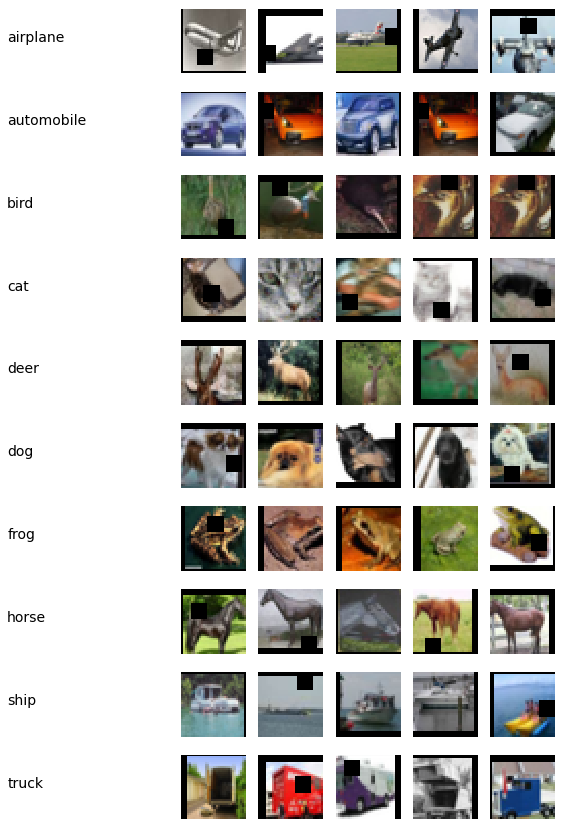

In [19]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [20]:
class GBN(torch.nn.Module):
    """
    Ghost Batch Normalization
    """

    def __init__(self, input_dim, virtual_batch_size=128, momentum=0.01):
        super(GBN, self).__init__()

        self.input_dim = input_dim
        self.virtual_batch_size = virtual_batch_size
        self.bn = nn.BatchNorm2d(self.input_dim, momentum=momentum)

    def forward(self, x):
        chunks = x.chunk(int(np.ceil(x.shape[0] / self.virtual_batch_size)), 0)
        res = [self.bn(x_) for x_ in chunks]

        return torch.cat(res, dim=0)

In [21]:
# def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)]
    
#     if max_pool:
#         layers.append(nn.MaxPool2d(2))

#     layers.extend([nn.BatchNorm2d(out_channels, momentum=0.9),
#                    nn.ReLU(inplace=True)])

#     return nn.Sequential(*layers)

"""Pre-activated approach, try with this now"""
def get_conv_block(in_channels=3, out_channels=64, max_pool=False):
    layers = [nn.BatchNorm2d(in_channels, momentum=0.9),
                   nn.ReLU(inplace=True)]
    
    if max_pool:
        layers.append(nn.MaxPool2d(2))

    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False))

    return nn.Sequential(*layers)

class CustomResNet(nn.Module):
    def __init__(self, in_planes, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        self.conv1 = get_conv_block(in_channels = in_planes, out_channels = 64)

        self.conv2 = get_conv_block(in_channels = 64, out_channels = 128, max_pool=True)

        self.res1 = nn.Sequential(get_conv_block(in_channels=128, out_channels=128), get_conv_block(in_channels=128, out_channels=128))
        
        self.conv3 = get_conv_block(128, 256, max_pool=True)

        self.conv4 = get_conv_block(256, 512, max_pool=True)
        
        self.res2 = nn.Sequential(get_conv_block(512, 512), get_conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes, bias=False))
        # self.extra_1 = nn.Sequential(
        #     nn.Conv2d(64, 128, 1, stride=2),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 256, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        
    def forward(self, x):
        x1 = out = self.conv1(x)
        out = self.conv2(out)
        out = out + self.res1(out)
        out = self.conv3(out) #+ self.extra_1(x1)
        out = self.conv4(out)
        out = out + self.res2(out)
        out = self.classifier(out)
        # out = out.view(-1, self.num_classes)
        # out = F.softmax(out, dim=-1)
        return out

In [22]:
model = CustomResNet(3, 10).to(device)

criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)
# criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
              ReLU-2            [-1, 3, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]           1,728
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,728
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
# from torch_lr_finder import LRFinder

# # optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9, nesterov=True, weight_decay=1e-5)
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [27]:
model = CustomResNet(3, 10).to(device)
# 0.02 with decay 1e-5 -> seems promising & 0.05 with 2e-5

max_lr = 2.6e-2
# 0.05, -> 
# 1) 2.49e-1, -> can take more 2) 2.91e-1 3) 3.1e-1,-> 84% & 82% can take more 4) 4.3e-1 -> can take more perhaps, try
# 5) 4.9e-1,  6) 5.9e-1 with opt lr 2.49e-2, 7) 5.1e-1 with 1.49e-2

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr = max_lr/10, nesterov=True, weight_decay=0.00025) # ["0.000125", "0.00025", "0.0005"]
# 2.49e-2, -> 3.4e-2, 

# optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,
                                                max_lr=max_lr,
                                                pct_start=0.35,
                                                anneal_strategy='linear',
                                                verbose=False,
                                                epochs=24,
                                                cycle_momentum=False,
                                                steps_per_epoch=len(train_loader))



train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
lr_epochs = []

start = time.perf_counter()

train_eval_model(model=model,
                 train_loader=train_loader,
                 optimizer = optimizer,
                 criterion=criterion,
                 device=device,
                 epochs=24,
                 test=True,
                 test_loader=test_loader,
                 scheduler=scheduler,
                 grad_clip=None,
                 noise_level=0,
                 ricap_apply=False)
                #  ricap_prob=0.05,
                #  ricap_beta=0.32)

end = time.perf_counter()

print(f"\n\nTime taken: {(end - start)//60} minutes and {int((end - start)%60)} seconds")

  0%|          | 0/98 [00:00<?, ?it/s]




epoch num ===================================== 1
LR at epoch 1 start: --> [0.00104]



100%|██████████| 98/98 [00:08<00:00, 11.21it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 17874/50000 (35.7480%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0032, accuracy: 4980/10000 (49.80000%)




epoch num ===================================== 2
LR at epoch 2 start: --> [0.004511586715867158]



100%|██████████| 98/98 [00:08<00:00, 11.70it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 13969/50000 (27.9380%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0036, accuracy: 4066/10000 (40.66000%)




epoch num ===================================== 3
LR at epoch 3 start: --> [0.007983173431734316]



100%|██████████| 98/98 [00:08<00:00, 11.63it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 19959/50000 (39.9180%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0037, accuracy: 4390/10000 (43.90000%)




epoch num ===================================== 4
LR at epoch 4 start: --> [0.011454760147601474]



100%|██████████| 98/98 [00:08<00:00, 11.79it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 23748/50000 (47.4960%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 5467/10000 (54.67000%)




epoch num ===================================== 5
LR at epoch 5 start: --> [0.014926346863468632]



100%|██████████| 98/98 [00:08<00:00, 11.76it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 24610/50000 (49.2200%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0030, accuracy: 5500/10000 (55.00000%)




epoch num ===================================== 6
LR at epoch 6 start: --> [0.01839793357933579]



100%|██████████| 98/98 [00:08<00:00, 11.08it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 28169/50000 (56.3380%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0027, accuracy: 6203/10000 (62.03000%)




epoch num ===================================== 7
LR at epoch 7 start: --> [0.02186952029520295]



100%|██████████| 98/98 [00:08<00:00, 11.04it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 30862/50000 (61.7240%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0026, accuracy: 6578/10000 (65.78000%)




epoch num ===================================== 8
LR at epoch 8 start: --> [0.025341107011070108]



100%|██████████| 98/98 [00:08<00:00, 11.14it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 33417/50000 (66.8340%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0026, accuracy: 6646/10000 (66.46000%)




epoch num ===================================== 9
LR at epoch 9 start: --> [0.024746117746355684]



100%|██████████| 98/98 [00:08<00:00, 11.74it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 35391/50000 (70.7820%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0024, accuracy: 7201/10000 (72.01000%)




epoch num ===================================== 10
LR at epoch 10 start: --> [0.023198504889212827]



100%|██████████| 98/98 [00:08<00:00, 11.65it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 36859/50000 (73.7180%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 7572/10000 (75.72000%)




epoch num ===================================== 11
LR at epoch 11 start: --> [0.02165089203206997]



100%|██████████| 98/98 [00:08<00:00, 11.79it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 38361/50000 (76.7220%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0022, accuracy: 7701/10000 (77.01000%)




epoch num ===================================== 12
LR at epoch 12 start: --> [0.020103279174927113]



100%|██████████| 98/98 [00:08<00:00, 11.92it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 39186/50000 (78.3720%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 7798/10000 (77.98000%)




epoch num ===================================== 13
LR at epoch 13 start: --> [0.018555666317784256]



100%|██████████| 98/98 [00:08<00:00, 10.95it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 40201/50000 (80.4020%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0021, accuracy: 7849/10000 (78.49000%)




epoch num ===================================== 14
LR at epoch 14 start: --> [0.017008053460641402]



100%|██████████| 98/98 [00:08<00:00, 10.97it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 40913/50000 (81.8260%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8067/10000 (80.67000%)




epoch num ===================================== 15
LR at epoch 15 start: --> [0.015460440603498543]



100%|██████████| 98/98 [00:08<00:00, 11.13it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 41597/50000 (83.1940%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0020, accuracy: 8110/10000 (81.10000%)




epoch num ===================================== 16
LR at epoch 16 start: --> [0.013912827746355685]



100%|██████████| 98/98 [00:08<00:00, 11.77it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 42125/50000 (84.2500%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8306/10000 (83.06000%)




epoch num ===================================== 17
LR at epoch 17 start: --> [0.01236521488921283]



100%|██████████| 98/98 [00:08<00:00, 11.62it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 42637/50000 (85.2740%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8276/10000 (82.76000%)




epoch num ===================================== 18
LR at epoch 18 start: --> [0.010817602032069972]



100%|██████████| 98/98 [00:08<00:00, 11.64it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43145/50000 (86.2900%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8369/10000 (83.69000%)




epoch num ===================================== 19
LR at epoch 19 start: --> [0.00926998917492711]



100%|██████████| 98/98 [00:08<00:00, 11.73it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43565/50000 (87.1300%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8302/10000 (83.02000%)




epoch num ===================================== 20
LR at epoch 20 start: --> [0.007722376317784257]



100%|██████████| 98/98 [00:08<00:00, 10.96it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 43905/50000 (87.8100%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0019, accuracy: 8431/10000 (84.31000%)




epoch num ===================================== 21
LR at epoch 21 start: --> [0.0061747634606414]



100%|██████████| 98/98 [00:08<00:00, 11.03it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44389/50000 (88.7780%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8479/10000 (84.79000%)




epoch num ===================================== 22
LR at epoch 22 start: --> [0.004627150603498543]



100%|██████████| 98/98 [00:08<00:00, 11.02it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44546/50000 (89.0920%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8482/10000 (84.82000%)




epoch num ===================================== 23
LR at epoch 23 start: --> [0.003079537746355686]



100%|██████████| 98/98 [00:08<00:00, 11.37it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 44923/50000 (89.8460%)



  0%|          | 0/98 [00:00<?, ?it/s]


	Test metrics: average loss: 0.0018, accuracy: 8528/10000 (85.28000%)




epoch num ===================================== 24
LR at epoch 24 start: --> [0.0015319248892128288]



100%|██████████| 98/98 [00:08<00:00, 10.94it/s]



Ricap applied: 0.00 percent of total batch iterations

			Train metrics: accuracy: 45091/50000 (90.1820%)



	Test metrics: average loss: 0.0018, accuracy: 8557/10000 (85.57000%)



Time taken: 3.0 minutes and 46 seconds


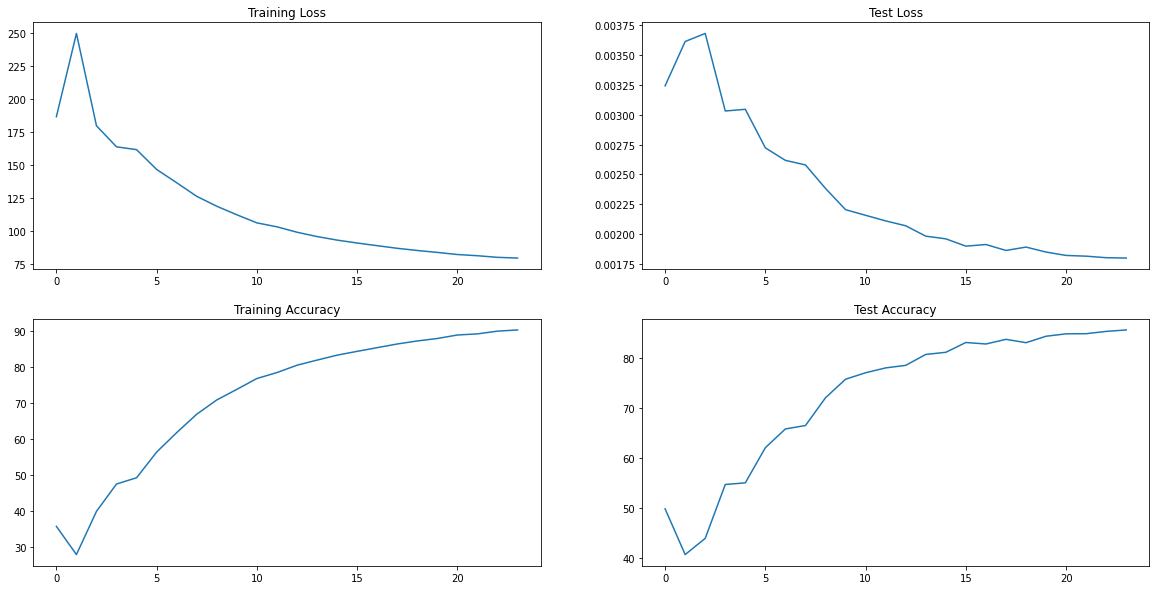

In [28]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)    

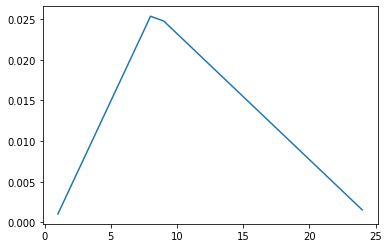

In [29]:
plt.plot(*zip(*lr_epochs))